# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [15]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

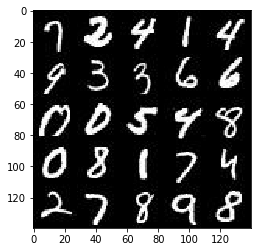

In [46]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

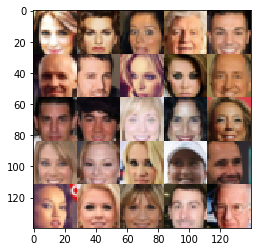

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real   = tf.placeholder(tf.float32, (None, image_width, 
                                                      image_height, 
                                                      image_channels), name='input_real')
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,  None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [20]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [111]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """    
    
    with tf.variable_scope('generator', reuse= not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now   
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [112]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [113]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [114]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [115]:
class GAN:
    def __init__(self, image_h, image_w, image_ch, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
    
        self.input_real, self.input_z, lr = model_inputs(image_h, image_w, image_ch, z_size)
        self.d_loss, self.g_loss          = model_loss(self.input_real, self.input_z, image_ch, alpha=alpha)
        self.d_opt, self.g_opt            = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [116]:
def scale(x):
    x *= 2
    return x

In [117]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    steps = 0
    print_every = 10
    show_every  = 100
    
    # extract image format
    image_h = data_shape[1]
    image_w = data_shape[2]
    image_ch = 1
    if data_image_mode == "RGB":
        image_ch = 3
        
    losses = []
    alpha = 0.2
    
    # Init the net
    net = GAN(image_h, image_w, image_ch, z_dim, learning_rate, alpha=alpha, beta1=beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # scaling up to [-1,1] range
                batch_images = scale(batch_images)
                
                #print(batch_images[0])
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, net.input_z, image_ch, data_image_mode)
  
        # Show final
        show_generator_output(sess, 32, net.input_z, image_ch, data_image_mode)
        
        # print the losses
        ax = pyplot.subplots()
        losses = np.array(losses)
        pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
        pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
        pyplot.title("Training Losses")
        pyplot.legend()
    
    print('done.')            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0064... Generator Loss: 8.6710
Epoch 1/2... Discriminator Loss: 0.0228... Generator Loss: 3.9919
Epoch 1/2... Discriminator Loss: 0.0031... Generator Loss: 8.4215
Epoch 1/2... Discriminator Loss: 0.0314... Generator Loss: 3.9204
Epoch 1/2... Discriminator Loss: 0.2997... Generator Loss: 3.4070
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 1.9614
Epoch 1/2... Discriminator Loss: 1.5563... Generator Loss: 2.9676
Epoch 1/2... Discriminator Loss: 1.0910... Generator Loss: 1.8589
Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 1.0344
Epoch 1/2... Discriminator Loss: 1.4826... Generator Loss: 0.5900


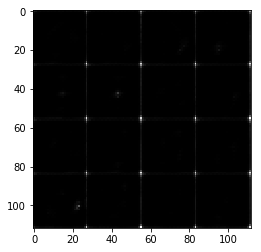

Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 0.5597
Epoch 1/2... Discriminator Loss: 1.6660... Generator Loss: 0.3400
Epoch 1/2... Discriminator Loss: 1.9200... Generator Loss: 0.2693
Epoch 1/2... Discriminator Loss: 1.7342... Generator Loss: 0.5363
Epoch 1/2... Discriminator Loss: 1.7572... Generator Loss: 0.3259
Epoch 1/2... Discriminator Loss: 1.5311... Generator Loss: 1.5523
Epoch 1/2... Discriminator Loss: 1.9675... Generator Loss: 0.1982
Epoch 1/2... Discriminator Loss: 1.4710... Generator Loss: 1.2121
Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 0.6990
Epoch 1/2... Discriminator Loss: 2.2414... Generator Loss: 0.1819


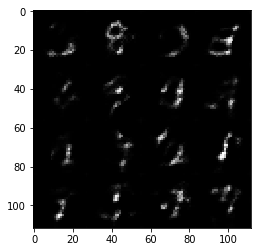

Epoch 1/2... Discriminator Loss: 1.6075... Generator Loss: 0.3118
Epoch 1/2... Discriminator Loss: 1.4324... Generator Loss: 1.0441
Epoch 1/2... Discriminator Loss: 1.9387... Generator Loss: 0.2033
Epoch 1/2... Discriminator Loss: 1.2256... Generator Loss: 0.9915
Epoch 1/2... Discriminator Loss: 1.4422... Generator Loss: 1.3427
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.5030
Epoch 1/2... Discriminator Loss: 1.5259... Generator Loss: 0.3741
Epoch 1/2... Discriminator Loss: 1.5641... Generator Loss: 0.3634
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 0.4263
Epoch 1/2... Discriminator Loss: 1.2661... Generator Loss: 0.7730


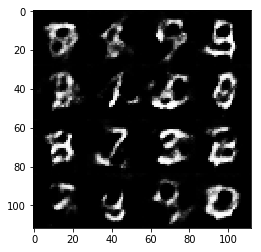

Epoch 1/2... Discriminator Loss: 1.4963... Generator Loss: 1.2354
Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 0.5641
Epoch 1/2... Discriminator Loss: 1.6586... Generator Loss: 0.2937
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.6273
Epoch 1/2... Discriminator Loss: 1.4180... Generator Loss: 0.4913
Epoch 1/2... Discriminator Loss: 1.5299... Generator Loss: 0.3675
Epoch 1/2... Discriminator Loss: 1.3116... Generator Loss: 0.4577
Epoch 1/2... Discriminator Loss: 1.4713... Generator Loss: 1.0976
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 0.9142
Epoch 1/2... Discriminator Loss: 1.5432... Generator Loss: 0.4090


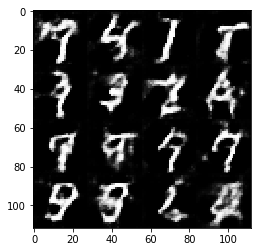

Epoch 1/2... Discriminator Loss: 1.7160... Generator Loss: 0.2626
Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 0.5172
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.5494
Epoch 1/2... Discriminator Loss: 1.6506... Generator Loss: 1.2728
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.7256
Epoch 1/2... Discriminator Loss: 1.4670... Generator Loss: 0.3975
Epoch 1/2... Discriminator Loss: 2.0265... Generator Loss: 0.1756
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.4519
Epoch 1/2... Discriminator Loss: 1.5109... Generator Loss: 0.4412
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 0.6004


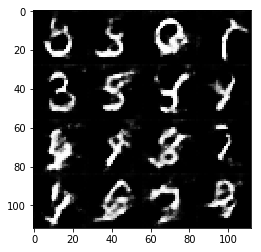

Epoch 1/2... Discriminator Loss: 1.4258... Generator Loss: 0.9641
Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.8058
Epoch 1/2... Discriminator Loss: 1.3161... Generator Loss: 0.6137
Epoch 1/2... Discriminator Loss: 1.3710... Generator Loss: 0.5767
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 0.4799
Epoch 1/2... Discriminator Loss: 1.3053... Generator Loss: 0.5349
Epoch 1/2... Discriminator Loss: 1.4329... Generator Loss: 0.4967
Epoch 1/2... Discriminator Loss: 1.3924... Generator Loss: 1.1194
Epoch 1/2... Discriminator Loss: 1.5174... Generator Loss: 0.3765
Epoch 1/2... Discriminator Loss: 1.5180... Generator Loss: 1.5252


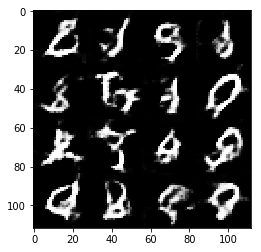

Epoch 1/2... Discriminator Loss: 1.5193... Generator Loss: 0.8451
Epoch 1/2... Discriminator Loss: 1.2937... Generator Loss: 0.8347
Epoch 1/2... Discriminator Loss: 1.3352... Generator Loss: 0.4468
Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 0.8689
Epoch 1/2... Discriminator Loss: 1.3692... Generator Loss: 0.4803
Epoch 1/2... Discriminator Loss: 1.8073... Generator Loss: 0.2422
Epoch 1/2... Discriminator Loss: 1.1849... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 1.5581... Generator Loss: 0.3666
Epoch 1/2... Discriminator Loss: 1.6156... Generator Loss: 0.3265
Epoch 1/2... Discriminator Loss: 1.3200... Generator Loss: 1.3269


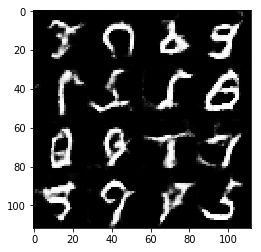

Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 0.4453
Epoch 1/2... Discriminator Loss: 1.4523... Generator Loss: 0.4387
Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 0.3899
Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 1.1738
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.4692
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 0.6079
Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 0.5198
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.5683
Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 0.4312
Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 0.4130


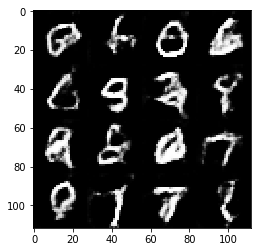

Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.4744
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 1.0968
Epoch 1/2... Discriminator Loss: 1.1665... Generator Loss: 0.9378
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.6713
Epoch 1/2... Discriminator Loss: 1.4457... Generator Loss: 0.5076
Epoch 1/2... Discriminator Loss: 1.1905... Generator Loss: 1.0415
Epoch 1/2... Discriminator Loss: 1.4680... Generator Loss: 1.3042
Epoch 1/2... Discriminator Loss: 1.5652... Generator Loss: 0.3163
Epoch 1/2... Discriminator Loss: 1.4639... Generator Loss: 0.3942
Epoch 1/2... Discriminator Loss: 1.7243... Generator Loss: 0.2794


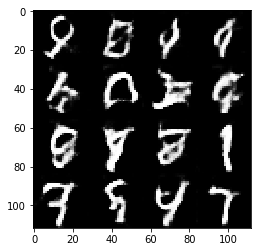

Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.6667... Generator Loss: 0.2725
Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 1.2475
Epoch 1/2... Discriminator Loss: 1.2941... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 1.4104... Generator Loss: 1.7893
Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.5247
Epoch 1/2... Discriminator Loss: 1.4534... Generator Loss: 1.0550
Epoch 1/2... Discriminator Loss: 1.2361... Generator Loss: 0.8910
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 1.0481
Epoch 1/2... Discriminator Loss: 1.1276... Generator Loss: 0.8405


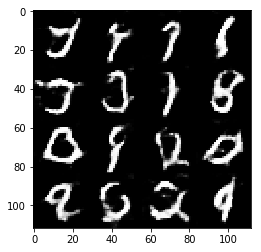

Epoch 1/2... Discriminator Loss: 1.3684... Generator Loss: 0.4805
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 0.3501
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.6265
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 0.6765
Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 0.4956
Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 1.0989
Epoch 1/2... Discriminator Loss: 1.1306... Generator Loss: 0.6640
Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 1.2560
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 0.5828


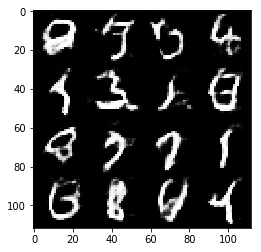

Epoch 1/2... Discriminator Loss: 1.1850... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 0.6757
Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 0.7653
Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 0.7406
Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 0.6422
Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 0.5290
Epoch 1/2... Discriminator Loss: 1.3259... Generator Loss: 0.4931
Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 1.0220
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.8327
Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 1.0942


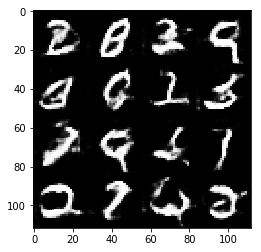

Epoch 1/2... Discriminator Loss: 1.2934... Generator Loss: 0.5838
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.4423
Epoch 1/2... Discriminator Loss: 1.4554... Generator Loss: 0.3708
Epoch 1/2... Discriminator Loss: 1.1824... Generator Loss: 0.8240
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 0.9921
Epoch 1/2... Discriminator Loss: 1.4493... Generator Loss: 0.4369
Epoch 1/2... Discriminator Loss: 1.4507... Generator Loss: 0.3961
Epoch 1/2... Discriminator Loss: 1.5404... Generator Loss: 0.3279
Epoch 1/2... Discriminator Loss: 1.5363... Generator Loss: 0.3180
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 0.8134


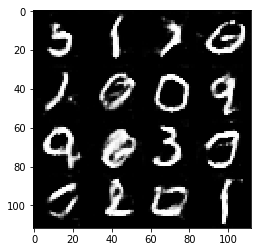

Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.3988
Epoch 1/2... Discriminator Loss: 1.5702... Generator Loss: 0.3122
Epoch 1/2... Discriminator Loss: 1.2752... Generator Loss: 0.7171
Epoch 1/2... Discriminator Loss: 1.2954... Generator Loss: 0.5740
Epoch 1/2... Discriminator Loss: 1.5707... Generator Loss: 1.4961
Epoch 1/2... Discriminator Loss: 1.5201... Generator Loss: 1.2239
Epoch 1/2... Discriminator Loss: 1.5626... Generator Loss: 1.0718
Epoch 1/2... Discriminator Loss: 1.2641... Generator Loss: 0.5168
Epoch 1/2... Discriminator Loss: 1.2783... Generator Loss: 0.5653
Epoch 1/2... Discriminator Loss: 1.1721... Generator Loss: 1.0617


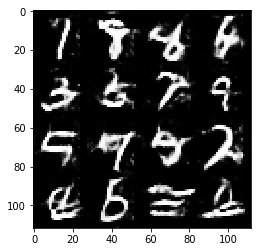

Epoch 1/2... Discriminator Loss: 1.4129... Generator Loss: 0.3879
Epoch 1/2... Discriminator Loss: 1.1661... Generator Loss: 1.3240
Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 1.0975
Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 1.1652
Epoch 1/2... Discriminator Loss: 1.1351... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 0.4521
Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 0.4499
Epoch 1/2... Discriminator Loss: 1.0983... Generator Loss: 0.8245
Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 0.9658
Epoch 1/2... Discriminator Loss: 2.1796... Generator Loss: 2.0382


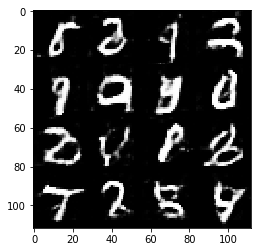

Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 0.6413
Epoch 1/2... Discriminator Loss: 1.2205... Generator Loss: 0.9241
Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 0.9088
Epoch 1/2... Discriminator Loss: 1.7488... Generator Loss: 0.2421
Epoch 1/2... Discriminator Loss: 1.0368... Generator Loss: 0.7870
Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 1.2702
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 0.7332
Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 0.7166
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.4405
Epoch 1/2... Discriminator Loss: 1.1651... Generator Loss: 0.8603


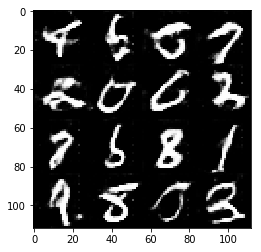

Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 0.8420
Epoch 1/2... Discriminator Loss: 1.4348... Generator Loss: 0.3809
Epoch 1/2... Discriminator Loss: 1.3270... Generator Loss: 0.4934
Epoch 1/2... Discriminator Loss: 1.3068... Generator Loss: 1.1282
Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 1.1492
Epoch 1/2... Discriminator Loss: 1.4636... Generator Loss: 2.1761
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 0.7866
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 1.1333
Epoch 1/2... Discriminator Loss: 1.3111... Generator Loss: 0.7531
Epoch 1/2... Discriminator Loss: 1.4365... Generator Loss: 0.4339


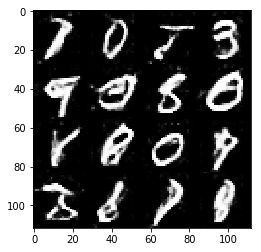

Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 0.7661
Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 0.6666
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 0.5698
Epoch 1/2... Discriminator Loss: 1.3841... Generator Loss: 0.4813
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 0.6802
Epoch 1/2... Discriminator Loss: 1.2845... Generator Loss: 0.5047
Epoch 1/2... Discriminator Loss: 1.1154... Generator Loss: 0.9161
Epoch 1/2... Discriminator Loss: 1.3717... Generator Loss: 1.3793
Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 0.5429
Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.4252


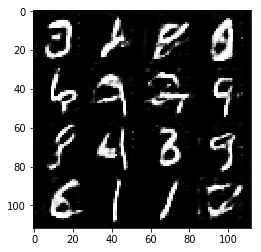

Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 0.4541
Epoch 1/2... Discriminator Loss: 1.2186... Generator Loss: 0.8482
Epoch 1/2... Discriminator Loss: 1.3369... Generator Loss: 1.2109
Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 0.8683
Epoch 1/2... Discriminator Loss: 1.6296... Generator Loss: 0.3203
Epoch 1/2... Discriminator Loss: 1.5228... Generator Loss: 1.6526
Epoch 1/2... Discriminator Loss: 1.2865... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 0.8042
Epoch 2/2... Discriminator Loss: 0.9853... Generator Loss: 1.0575
Epoch 2/2... Discriminator Loss: 1.2534... Generator Loss: 0.6573


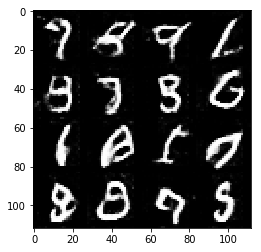

Epoch 2/2... Discriminator Loss: 1.9561... Generator Loss: 1.7351
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.4515
Epoch 2/2... Discriminator Loss: 1.4682... Generator Loss: 0.3910
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.4552... Generator Loss: 0.3545
Epoch 2/2... Discriminator Loss: 1.6543... Generator Loss: 1.8054
Epoch 2/2... Discriminator Loss: 1.4200... Generator Loss: 0.4203
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 0.6445
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 1.1036
Epoch 2/2... Discriminator Loss: 1.7806... Generator Loss: 0.2357


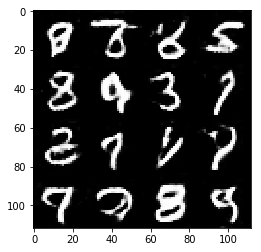

Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.4540
Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 0.8949
Epoch 2/2... Discriminator Loss: 1.2190... Generator Loss: 0.7310
Epoch 2/2... Discriminator Loss: 1.4156... Generator Loss: 0.4451
Epoch 2/2... Discriminator Loss: 1.2648... Generator Loss: 1.4830
Epoch 2/2... Discriminator Loss: 1.2518... Generator Loss: 0.6308
Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 0.4832
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.4441
Epoch 2/2... Discriminator Loss: 1.3924... Generator Loss: 0.4232
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.6719


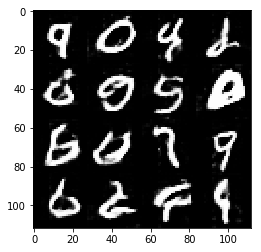

Epoch 2/2... Discriminator Loss: 1.4615... Generator Loss: 1.2646
Epoch 2/2... Discriminator Loss: 1.1486... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 1.0101
Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 1.0986
Epoch 2/2... Discriminator Loss: 1.4570... Generator Loss: 0.3770
Epoch 2/2... Discriminator Loss: 1.2713... Generator Loss: 0.7857
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.8375
Epoch 2/2... Discriminator Loss: 1.5649... Generator Loss: 1.3163
Epoch 2/2... Discriminator Loss: 1.2926... Generator Loss: 1.1003
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 1.1197


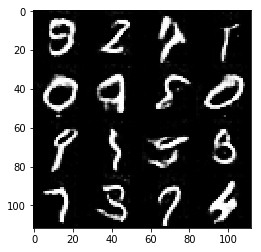

Epoch 2/2... Discriminator Loss: 1.0680... Generator Loss: 1.3856
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 0.6074
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 0.4617
Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 1.0873
Epoch 2/2... Discriminator Loss: 1.1585... Generator Loss: 0.7664
Epoch 2/2... Discriminator Loss: 1.2042... Generator Loss: 0.8345
Epoch 2/2... Discriminator Loss: 1.8976... Generator Loss: 0.2178
Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 0.6516
Epoch 2/2... Discriminator Loss: 1.6579... Generator Loss: 1.5850
Epoch 2/2... Discriminator Loss: 1.1984... Generator Loss: 1.1039


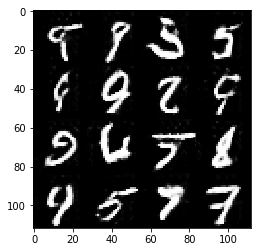

Epoch 2/2... Discriminator Loss: 1.2490... Generator Loss: 0.8038
Epoch 2/2... Discriminator Loss: 1.7558... Generator Loss: 1.4472
Epoch 2/2... Discriminator Loss: 1.3879... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 0.6546
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.8501
Epoch 2/2... Discriminator Loss: 1.2298... Generator Loss: 0.8677
Epoch 2/2... Discriminator Loss: 1.2687... Generator Loss: 1.0112
Epoch 2/2... Discriminator Loss: 1.2711... Generator Loss: 0.5373
Epoch 2/2... Discriminator Loss: 1.2961... Generator Loss: 0.6118
Epoch 2/2... Discriminator Loss: 1.0937... Generator Loss: 0.6758


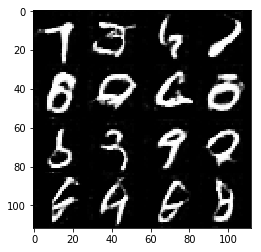

Epoch 2/2... Discriminator Loss: 1.2291... Generator Loss: 1.4026
Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 0.8207
Epoch 2/2... Discriminator Loss: 1.4573... Generator Loss: 1.0728
Epoch 2/2... Discriminator Loss: 1.3191... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 1.3696... Generator Loss: 0.4382
Epoch 2/2... Discriminator Loss: 1.7276... Generator Loss: 0.2478
Epoch 2/2... Discriminator Loss: 1.1349... Generator Loss: 0.7510
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 0.7764
Epoch 2/2... Discriminator Loss: 1.1326... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.4658... Generator Loss: 0.3750


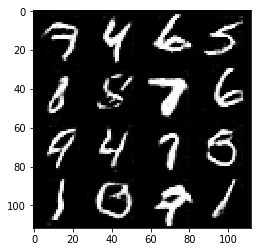

Epoch 2/2... Discriminator Loss: 1.3512... Generator Loss: 0.4463
Epoch 2/2... Discriminator Loss: 1.0543... Generator Loss: 1.2284
Epoch 2/2... Discriminator Loss: 1.2706... Generator Loss: 0.5100
Epoch 2/2... Discriminator Loss: 1.4830... Generator Loss: 0.3742
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.4749
Epoch 2/2... Discriminator Loss: 1.1181... Generator Loss: 0.9073
Epoch 2/2... Discriminator Loss: 1.2558... Generator Loss: 0.5009
Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.7394
Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 0.8685
Epoch 2/2... Discriminator Loss: 1.0492... Generator Loss: 0.7375


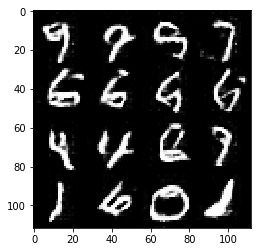

Epoch 2/2... Discriminator Loss: 1.3426... Generator Loss: 1.0771
Epoch 2/2... Discriminator Loss: 1.1242... Generator Loss: 0.6491
Epoch 2/2... Discriminator Loss: 1.0830... Generator Loss: 0.6850
Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 1.2638... Generator Loss: 0.6175
Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 1.4411
Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 0.6400
Epoch 2/2... Discriminator Loss: 1.5639... Generator Loss: 0.3649
Epoch 2/2... Discriminator Loss: 1.0754... Generator Loss: 1.1336
Epoch 2/2... Discriminator Loss: 1.1215... Generator Loss: 0.5822


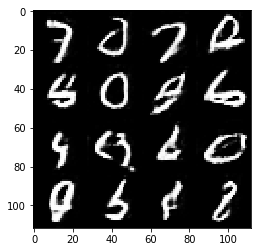

Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.4244
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 1.0514
Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 1.0099
Epoch 2/2... Discriminator Loss: 1.5138... Generator Loss: 0.3599
Epoch 2/2... Discriminator Loss: 1.4329... Generator Loss: 0.3831
Epoch 2/2... Discriminator Loss: 1.1347... Generator Loss: 0.5613
Epoch 2/2... Discriminator Loss: 1.4918... Generator Loss: 1.2173
Epoch 2/2... Discriminator Loss: 1.2367... Generator Loss: 1.4626
Epoch 2/2... Discriminator Loss: 1.0287... Generator Loss: 0.8626
Epoch 2/2... Discriminator Loss: 1.4030... Generator Loss: 0.5114


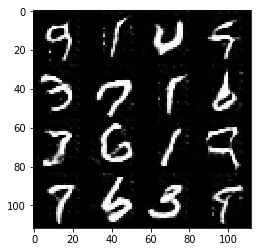

Epoch 2/2... Discriminator Loss: 1.2941... Generator Loss: 1.1648
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.5706
Epoch 2/2... Discriminator Loss: 1.5913... Generator Loss: 0.3023
Epoch 2/2... Discriminator Loss: 1.0962... Generator Loss: 0.8246
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 0.9990
Epoch 2/2... Discriminator Loss: 1.2697... Generator Loss: 0.8532
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 0.4252
Epoch 2/2... Discriminator Loss: 1.1794... Generator Loss: 0.5688
Epoch 2/2... Discriminator Loss: 1.2506... Generator Loss: 0.4542
Epoch 2/2... Discriminator Loss: 1.3170... Generator Loss: 1.2718


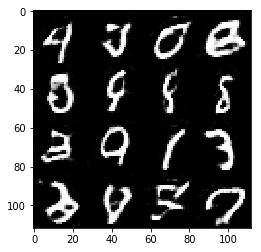

Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.9686
Epoch 2/2... Discriminator Loss: 1.6696... Generator Loss: 0.3015
Epoch 2/2... Discriminator Loss: 1.1917... Generator Loss: 0.9866
Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 0.4752
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.6316
Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 0.8635
Epoch 2/2... Discriminator Loss: 1.0778... Generator Loss: 1.6550
Epoch 2/2... Discriminator Loss: 1.2414... Generator Loss: 0.6909
Epoch 2/2... Discriminator Loss: 0.9805... Generator Loss: 1.1280
Epoch 2/2... Discriminator Loss: 1.2229... Generator Loss: 0.7170


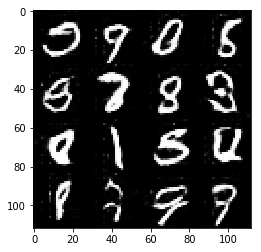

Epoch 2/2... Discriminator Loss: 1.5348... Generator Loss: 0.3302
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 0.5735
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 1.4409
Epoch 2/2... Discriminator Loss: 1.0617... Generator Loss: 1.3757
Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 1.1399
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 0.5833
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 0.6544
Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 0.4560
Epoch 2/2... Discriminator Loss: 1.6562... Generator Loss: 0.2878
Epoch 2/2... Discriminator Loss: 1.2320... Generator Loss: 1.8309


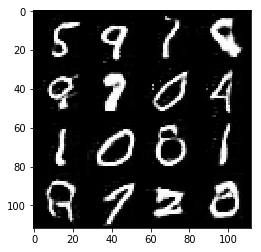

Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 0.6277
Epoch 2/2... Discriminator Loss: 1.1153... Generator Loss: 0.6553
Epoch 2/2... Discriminator Loss: 0.9607... Generator Loss: 1.0088
Epoch 2/2... Discriminator Loss: 1.1950... Generator Loss: 0.5261
Epoch 2/2... Discriminator Loss: 1.0003... Generator Loss: 0.8278
Epoch 2/2... Discriminator Loss: 1.0354... Generator Loss: 1.3204
Epoch 2/2... Discriminator Loss: 1.3795... Generator Loss: 0.4364
Epoch 2/2... Discriminator Loss: 1.2066... Generator Loss: 0.4545
Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 0.8403
Epoch 2/2... Discriminator Loss: 1.0637... Generator Loss: 0.9507


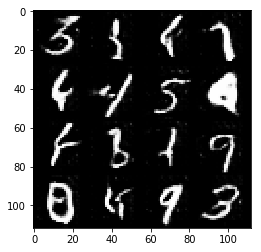

Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 0.9554
Epoch 2/2... Discriminator Loss: 1.2525... Generator Loss: 1.3837
Epoch 2/2... Discriminator Loss: 1.0962... Generator Loss: 0.9020
Epoch 2/2... Discriminator Loss: 1.2718... Generator Loss: 0.5683
Epoch 2/2... Discriminator Loss: 1.3634... Generator Loss: 1.0611
Epoch 2/2... Discriminator Loss: 1.2473... Generator Loss: 0.5558
Epoch 2/2... Discriminator Loss: 0.9608... Generator Loss: 0.8320
Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 0.6854
Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 0.5313
Epoch 2/2... Discriminator Loss: 1.4625... Generator Loss: 0.4644


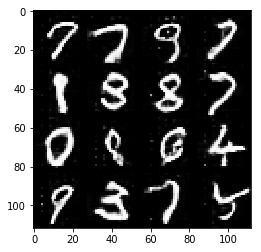

Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 1.3463
Epoch 2/2... Discriminator Loss: 1.2306... Generator Loss: 0.8514
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 0.7641
Epoch 2/2... Discriminator Loss: 1.3171... Generator Loss: 0.5287
Epoch 2/2... Discriminator Loss: 1.4243... Generator Loss: 0.3932
Epoch 2/2... Discriminator Loss: 1.6896... Generator Loss: 0.2631
Epoch 2/2... Discriminator Loss: 1.1489... Generator Loss: 0.6967
Epoch 2/2... Discriminator Loss: 1.4424... Generator Loss: 0.4085
Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 0.7585
Epoch 2/2... Discriminator Loss: 1.2429... Generator Loss: 0.4514


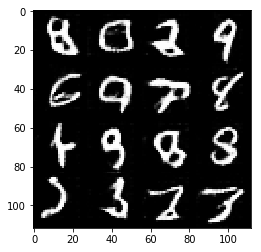

Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 0.5245
Epoch 2/2... Discriminator Loss: 1.6857... Generator Loss: 1.3877
Epoch 2/2... Discriminator Loss: 1.0290... Generator Loss: 0.6797
Epoch 2/2... Discriminator Loss: 1.2764... Generator Loss: 0.9375
Epoch 2/2... Discriminator Loss: 1.2734... Generator Loss: 0.5772
Epoch 2/2... Discriminator Loss: 1.0016... Generator Loss: 0.8134
Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 0.6315
Epoch 2/2... Discriminator Loss: 1.2153... Generator Loss: 0.9414
Epoch 2/2... Discriminator Loss: 1.4171... Generator Loss: 0.4161
Epoch 2/2... Discriminator Loss: 0.9936... Generator Loss: 1.3235


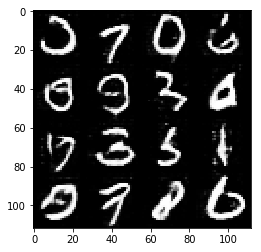

Epoch 2/2... Discriminator Loss: 0.9627... Generator Loss: 0.9006
Epoch 2/2... Discriminator Loss: 1.5043... Generator Loss: 0.3992
Epoch 2/2... Discriminator Loss: 1.1625... Generator Loss: 0.7807
Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 1.2185
Epoch 2/2... Discriminator Loss: 1.3059... Generator Loss: 0.6447
Epoch 2/2... Discriminator Loss: 1.2433... Generator Loss: 0.4898
Epoch 2/2... Discriminator Loss: 1.5866... Generator Loss: 1.4092
Epoch 2/2... Discriminator Loss: 1.0946... Generator Loss: 1.1483
Epoch 2/2... Discriminator Loss: 1.1665... Generator Loss: 0.5951
Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 1.0613


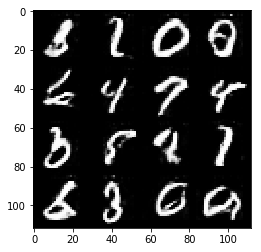

Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 0.6021
Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 0.5556
Epoch 2/2... Discriminator Loss: 1.3722... Generator Loss: 0.4700
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 1.0051
Epoch 2/2... Discriminator Loss: 1.1286... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 1.4570... Generator Loss: 0.3621
Epoch 2/2... Discriminator Loss: 1.1668... Generator Loss: 0.6422
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.6397
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 1.1836


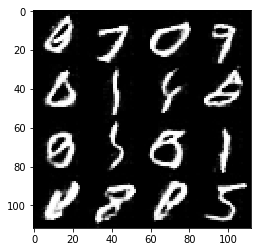

Epoch 2/2... Discriminator Loss: 1.1366... Generator Loss: 0.8707
Epoch 2/2... Discriminator Loss: 1.2029... Generator Loss: 0.9633
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 0.4036
Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 1.9268
Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 1.2161


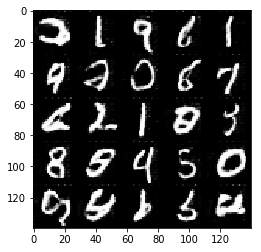

done.


IndexError: list index out of range

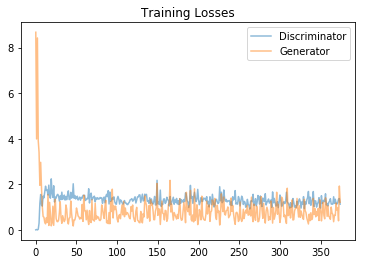

In [119]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2548... Generator Loss: 1.7686
Epoch 1/1... Discriminator Loss: 0.0279... Generator Loss: 8.2875
Epoch 1/1... Discriminator Loss: 0.1114... Generator Loss: 2.4564
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 9.4891
Epoch 1/1... Discriminator Loss: 0.0310... Generator Loss: 9.5086
Epoch 1/1... Discriminator Loss: 0.0791... Generator Loss: 7.9598
Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 2.1538
Epoch 1/1... Discriminator Loss: 0.3067... Generator Loss: 3.3148
Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 1.7435
Epoch 1/1... Discriminator Loss: 0.1734... Generator Loss: 2.3829


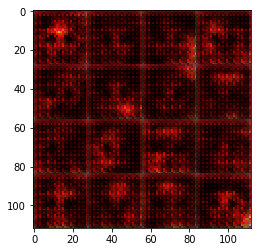

Epoch 1/1... Discriminator Loss: 0.2780... Generator Loss: 1.9322
Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 2.1213
Epoch 1/1... Discriminator Loss: 3.0060... Generator Loss: 9.9361
Epoch 1/1... Discriminator Loss: 0.3878... Generator Loss: 1.7204
Epoch 1/1... Discriminator Loss: 0.1049... Generator Loss: 2.8915
Epoch 1/1... Discriminator Loss: 0.0676... Generator Loss: 3.2432
Epoch 1/1... Discriminator Loss: 0.0356... Generator Loss: 4.2460
Epoch 1/1... Discriminator Loss: 0.0430... Generator Loss: 3.7317
Epoch 1/1... Discriminator Loss: 0.0956... Generator Loss: 2.9470
Epoch 1/1... Discriminator Loss: 0.0709... Generator Loss: 4.6518


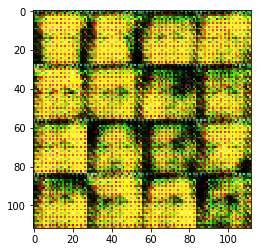

Epoch 1/1... Discriminator Loss: 0.0278... Generator Loss: 4.1861
Epoch 1/1... Discriminator Loss: 0.0409... Generator Loss: 5.0408
Epoch 1/1... Discriminator Loss: 0.0312... Generator Loss: 4.1609
Epoch 1/1... Discriminator Loss: 0.0242... Generator Loss: 4.6929
Epoch 1/1... Discriminator Loss: 0.0321... Generator Loss: 3.8420
Epoch 1/1... Discriminator Loss: 0.0347... Generator Loss: 3.9810
Epoch 1/1... Discriminator Loss: 0.0294... Generator Loss: 3.8377
Epoch 1/1... Discriminator Loss: 0.2419... Generator Loss: 6.7175
Epoch 1/1... Discriminator Loss: 0.2849... Generator Loss: 7.3296
Epoch 1/1... Discriminator Loss: 2.6449... Generator Loss: 0.1219


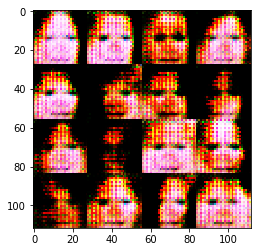

Epoch 1/1... Discriminator Loss: 0.1807... Generator Loss: 3.2511
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 1.7272
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 2.0117... Generator Loss: 5.1860
Epoch 1/1... Discriminator Loss: 1.9159... Generator Loss: 4.5797
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 2.2232
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.3373
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 1.3534
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 1.3072


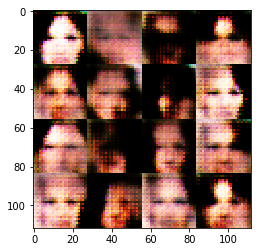

Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 2.0666
Epoch 1/1... Discriminator Loss: 0.5501... Generator Loss: 1.5716
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 1.5631
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 1.6418
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 2.3090
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.4618


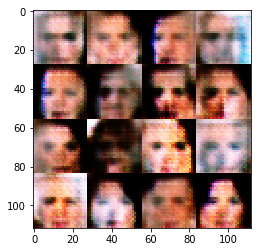

Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.4756
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 3.8959
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.4742
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.4241
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.6925


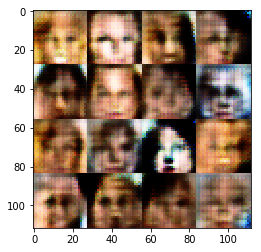

Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 1.8249
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 1.9995
Epoch 1/1... Discriminator Loss: 1.7370... Generator Loss: 0.3266
Epoch 1/1... Discriminator Loss: 1.5525... Generator Loss: 0.3469
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 1.3238
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.8766


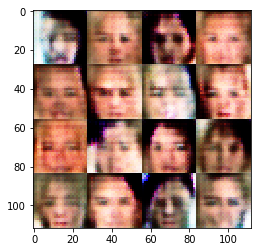

Epoch 1/1... Discriminator Loss: 1.8838... Generator Loss: 2.3905
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 1.7497
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 2.9397
Epoch 1/1... Discriminator Loss: 2.0331... Generator Loss: 0.2220
Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 1.9195
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.0284
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 3.5962
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 1.7945


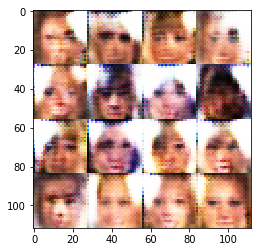

Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.6402... Generator Loss: 2.1945
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 2.3511
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.3272


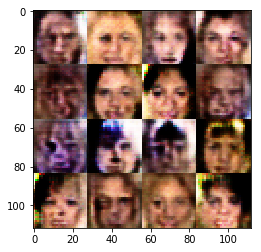

Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.5312... Generator Loss: 1.6798
Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 1.2084
Epoch 1/1... Discriminator Loss: 0.9997... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.7575... Generator Loss: 0.3947
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 1.5080
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.7077


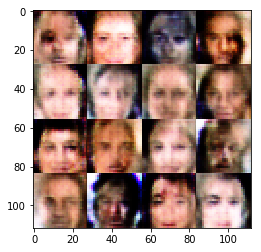

Epoch 1/1... Discriminator Loss: 1.8638... Generator Loss: 0.3003
Epoch 1/1... Discriminator Loss: 1.9867... Generator Loss: 0.2056
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 2.1742
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 1.8709
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 2.1235... Generator Loss: 0.1968


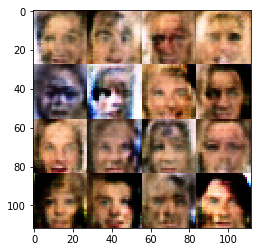

Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 1.0678
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.7477... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 1.1101


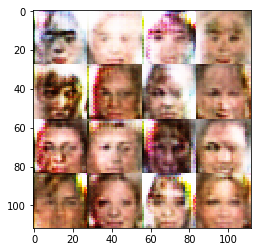

Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.7780... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 1.6506... Generator Loss: 0.4175
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 1.4551
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 1.6856
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 1.1429
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.5932


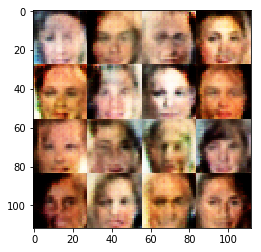

Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 2.0561
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 1.4143
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.3607
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 4.4843


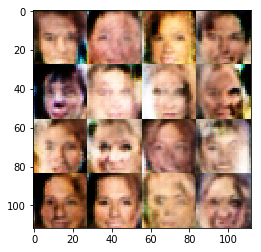

Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.7333... Generator Loss: 0.2576
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 1.0489
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6509


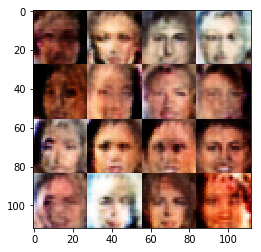

Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 1.5731
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.4528
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 1.5534
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.6652... Generator Loss: 0.3955
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.9486
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 1.1991


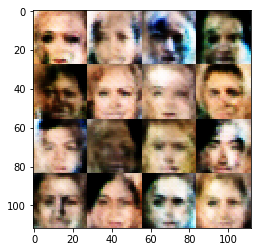

Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 1.1549... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.4838
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.3794
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 1.3039
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.0536


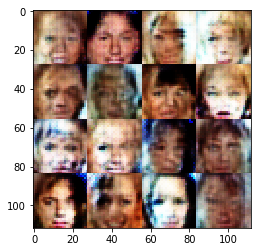

Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.4245
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.6297... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.9129
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6038


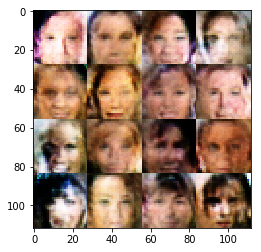

Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 1.6965
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.4482
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 2.2097... Generator Loss: 2.3982
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 1.3045
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 1.8525
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 1.2319


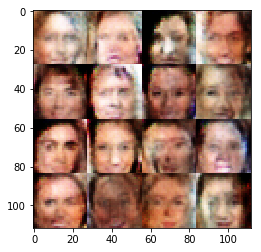

Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.3883
Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 1.5375
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.3690
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.9324


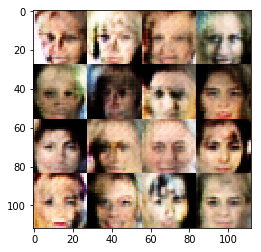

Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 1.3279
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 1.6516... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.5279


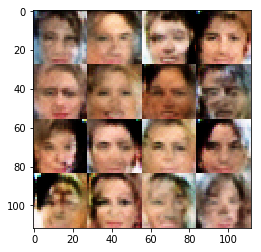

Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 1.8438... Generator Loss: 0.3047
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.9020


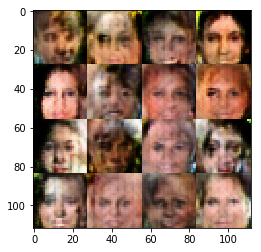

Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 1.3292
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.7153... Generator Loss: 0.3110
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6647


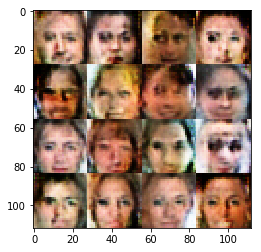

Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.4448
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.8961
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 1.6200... Generator Loss: 0.4747
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.3258


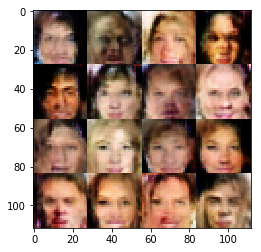

Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 1.2407
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 1.2420
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.7368


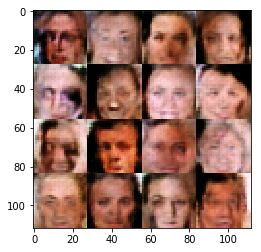

Epoch 1/1... Discriminator Loss: 1.7809... Generator Loss: 0.2710
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 1.8352
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.5227


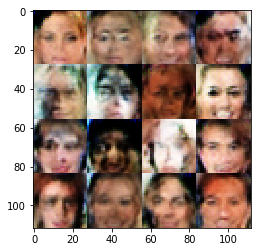

Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 2.1461
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.4512
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6020


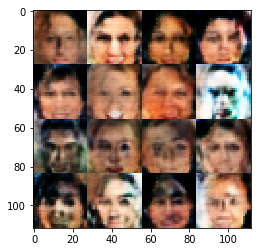

Epoch 1/1... Discriminator Loss: 1.7177... Generator Loss: 1.8067
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.4864
Epoch 1/1... Discriminator Loss: 1.6103... Generator Loss: 0.3592
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.6241


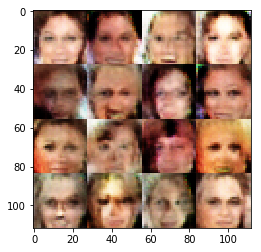

Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 1.4814
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 1.2914
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 1.7638... Generator Loss: 0.3020
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.9518
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.5471... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.6847


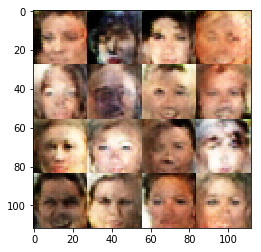

Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 1.3608
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.6150... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.5916... Generator Loss: 1.2831


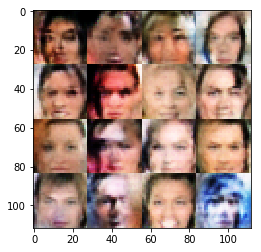

Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 1.2476
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 1.2444
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 0.7625


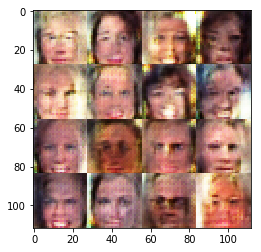

Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 1.4919
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.5816


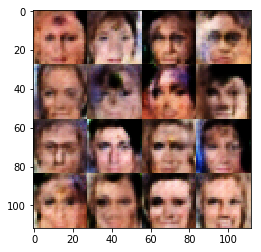

Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.4617
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 1.6812
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.3415
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.6387... Generator Loss: 0.4554
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.4724
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.9753


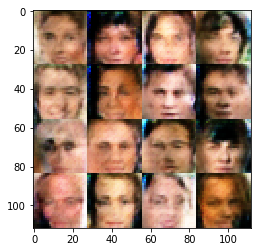

Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.3800
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 2.2412... Generator Loss: 2.0791
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.8199


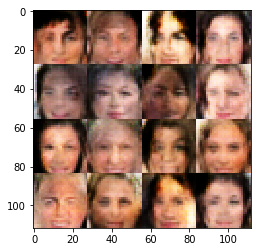

Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 1.6777
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 1.2149


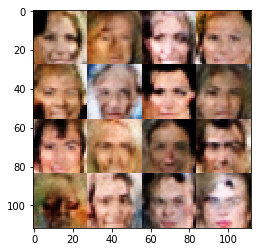

Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.7151... Generator Loss: 0.3928
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.7709
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.9297


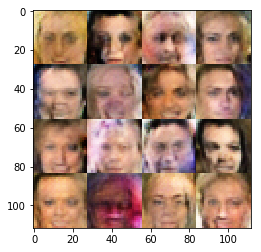

Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 1.0578
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 1.6780
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.8237


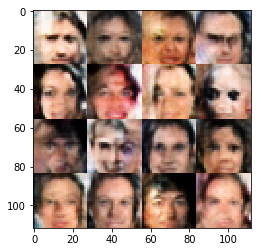

Epoch 1/1... Discriminator Loss: 1.6706... Generator Loss: 0.3532
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.8195


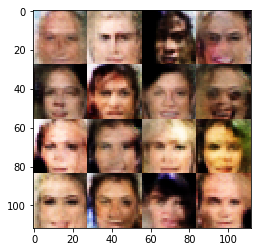

Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 1.6698... Generator Loss: 0.3966
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.7522


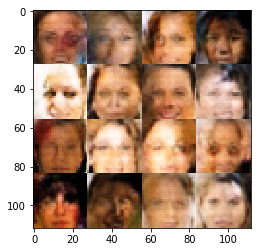

Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.8491... Generator Loss: 0.3059
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 1.1408
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 1.0975
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.6636


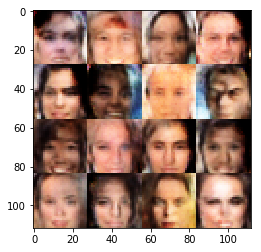

Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.3846


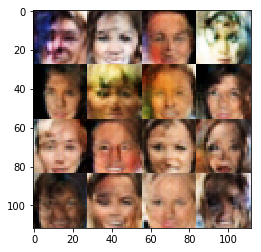

Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.6176... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.9820
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 1.7013... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.4411


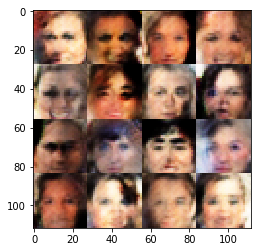

Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 1.8086... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 1.2295
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.6868... Generator Loss: 0.3631
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 1.0681
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6961


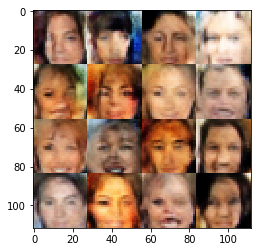

Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 1.3372
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6609


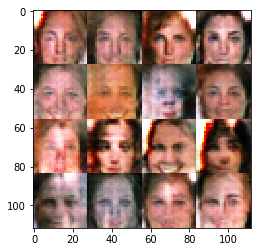

Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7772


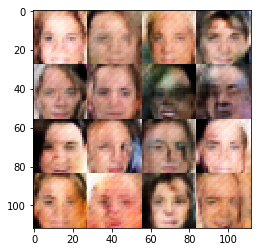

Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.3449
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.8117


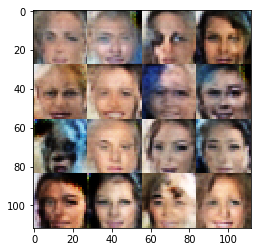

Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.5121
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 1.0704


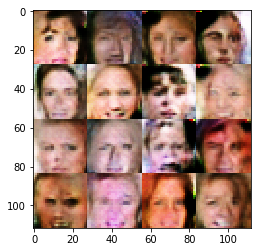

Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.4789
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 1.1690
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.6615... Generator Loss: 0.3399


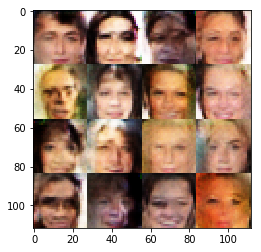

Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.5784... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.5657... Generator Loss: 0.8928


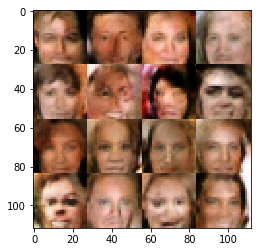

Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.4716
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.5233


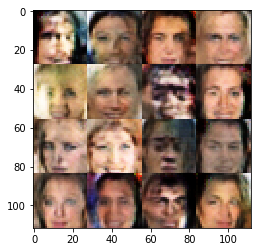

Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.6546
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 1.4303
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.6637


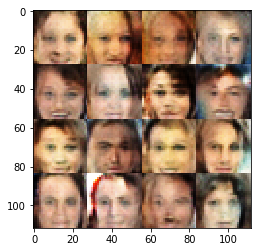

Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 2.2735
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 1.0130
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 1.1928
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.7783


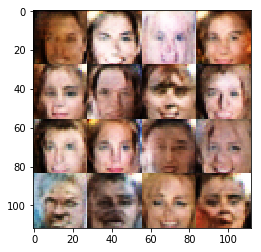

Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 0.5018... Generator Loss: 1.6594
Epoch 1/1... Discriminator Loss: 0.3001... Generator Loss: 2.1844
Epoch 1/1... Discriminator Loss: 0.5855... Generator Loss: 1.7904
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 1.9097
Epoch 1/1... Discriminator Loss: 1.8154... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7193


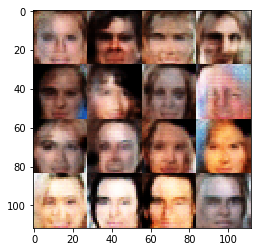

Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.5626
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.5065


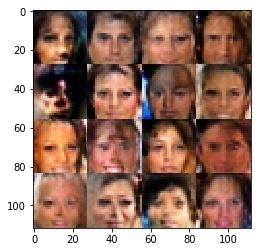

Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 1.2751
Epoch 1/1... Discriminator Loss: 1.6425... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7596


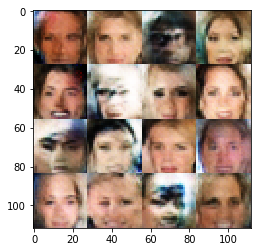

Epoch 1/1... Discriminator Loss: 1.6051... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7386


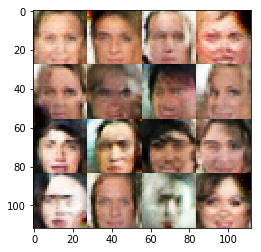

Epoch 1/1... Discriminator Loss: 1.6917... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6631


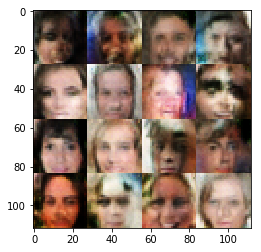

Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 1.2786
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.7180


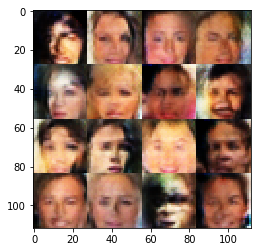

Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.5848... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.5819


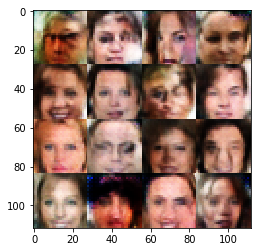

Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.6027... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.4184
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.6601


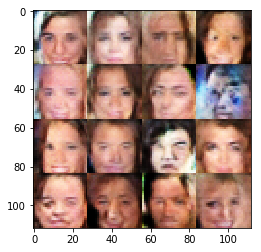

Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.3653
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.8925


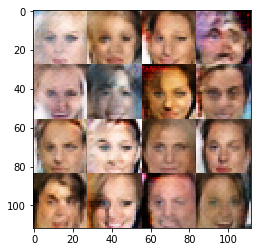

Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 1.6937... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.5640


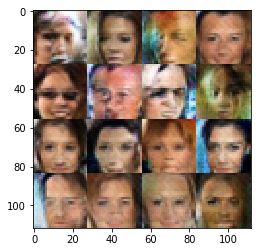

Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.4914
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.7855... Generator Loss: 0.3999
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.5445... Generator Loss: 0.5143


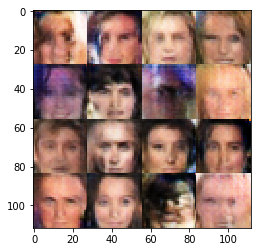

Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7358


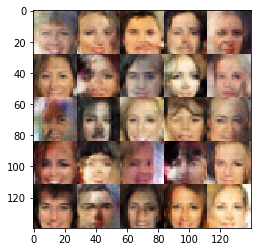

done.


IndexError: list index out of range

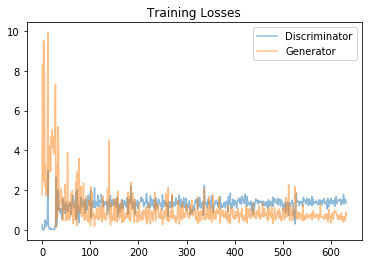

In [123]:

batch_size = 32
z_dim = 200
learning_rate = 0.0005
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.